# data notebook

### imports

In [13]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### raw data prep

#### renaming columns

In [14]:
data_raw = pd.read_csv('blood_data_raw.csv')
data_raw['time'] = pd.to_datetime(data_raw['YEAR'].astype(str) + '-' + data_raw['MONTH'] + '-01', format='%Y-%B-%d')
data_raw = data_raw.rename(columns = {'QTY_DEMANDED': 'demand', 'QTY_SUPPLIED': 'supply'})
data_raw = data_raw.drop(['YEAR', 'MONTH'], axis = 1)
data_raw = data_raw[['time', 'supply', 'demand']]

#### data trim and prep

In [15]:
data_raw = data_raw.set_index('time')
#outliers
data_raw.loc['2017-03-01', ['supply', 'demand']] = np.nan
data_raw.loc['2017-06-01', ['supply', 'demand']] = np.nan
index = pd.date_range(start=data_raw.index.min(), end=data_raw.index.max())
data_raw = data_raw.reindex(index)

In [16]:
def plot_data(df):
    plt.plot(df['demand'], label = 'demand', markersize = 1, marker = 'o')
    plt.plot(df['supply'], label = 'supply', markersize = 1, marker = 'o')
    plt.legend()
    plt.title('raw data')
    plt.xlabel('time')
    plt.ylabel('units of blood per day')
    plt.show()

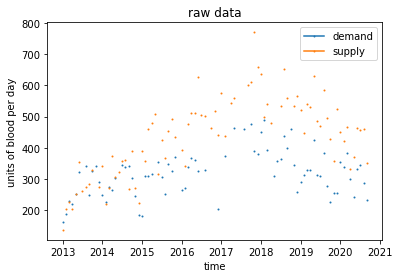

In [17]:
plot_data(data_raw)

### interpolate to daily + fix missing values

In [18]:
def interpolate_monthly_to_daily(df, interp_type='cubic'):

    index = pd.date_range(start=df.index.min(), end=df.index.max())
    df = df.reindex(index)
    
    # Perform interpolation on all columns except the first one (the time column)
    df.iloc[:, :] = df.apply(
        lambda col: interp1d(col.index[~col.isna()], col.dropna(), kind=interp_type, fill_value='extrapolate')(col.index) 
                      if len(col.dropna()) > 1 else col, 
        axis=0
    )
    
    return df /30

#### Cubic spline

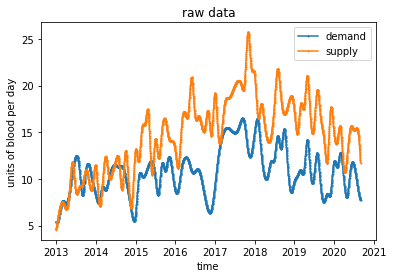

In [19]:
data_cubterp = interpolate_monthly_to_daily(data_raw, interp_type = 'cubic')
plot_data(data_cubterp)

### adding structure and noise

#### weekly-periodic structure
disabled for now

In [20]:
L, shift = 7, 3
amp_sup, amp_dem = 0,0 #0.1,0.11
x = np.arange(0,len(data_cubterp))
weekly_structure = np.array([amp_sup *  np.cos(2*np.pi*(x+shift)/L), amp_dem *  np.cos(2*np.pi*(x+shift)/L)]).T

#### zero-mean gaussian noise

In [21]:
std_dev = 0.0
noise = np.random.normal(loc=0, scale=std_dev, size=data_cubterp.shape)

#### final data

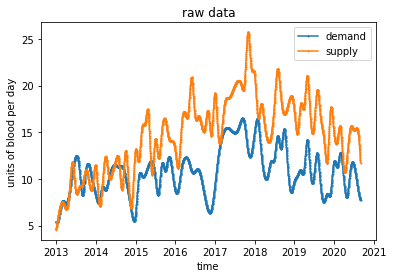

In [22]:
scale_sup = 1.0
scale_dem = 1.0

data = data_cubterp + weekly_structure + noise

data['supply'] = scale_sup*data['supply']
data['demand'] = scale_dem*data['demand']

plot_data(data)
# plot_data(data['2014-01-01':'2014-01-14'])
# plot_data(data_cubterp['2014-01-01':'2014-01-14'])

### formatting and export!

In [23]:
data = data.reset_index()
data.rename(columns={'index': 'times'},inplace=True)
file_name = 'data_synth.csv'
#data = data[0:365]
data.to_csv(file_name,index=False)